# Proximal Policy Optimization (PPO)

## 1. 算法原理

PPO 是一种常用的强化学习算法，属于策略梯度方法的一种改进版本。其核心思想是在更新策略时避免过大的变化，以防止策略在训练中变得不稳定或遭到破坏。

在策略梯度算法中，目标是通过提升动作在某状态下被策略采样的概率来优化策略。最常见的策略梯度表达式为：

$$
\hat{g} = \hat{\mathbb{E}_t} \left[ \nabla_\theta \log {\pi_\theta} (a_t \mid s_t) \hat{A}_t \right]
$$

其中：
- $\pi_\theta(a_t \mid s_t)$ 是参数为 $\theta$ 的策略，表示在状态 $s_t$ 下执行动作 $a_t$ 的概率。
- $\hat{A}_t$ 是 advantage 估计，表示在时间步 $t$ 时某个动作相对于平均策略的好坏程度。
- $\hat{g}$ 是策略梯度，用于调整策略参数 $\theta$。

这种策略梯度方法可以通过最大化以下损失函数来实现策略优化：

$$
L^{PG}(\theta) = \hat{\mathbb{E}}_t \left[ \log {\pi_\theta}(a_t \mid s_t) \hat{A}_t \right]
$$

然而，直接通过多步更新该损失函数可能会导致策略变化过大，从而使得模型不稳定甚至被破坏。

为了控制策略的更新幅度，PPO 引入了一个比率 $r_t(\theta)$，用于比较更新前后的策略变化：

$$
r_t(\theta) = \frac{\pi_\theta (a_t \mid s_t)}{\pi_{\theta_{\text{old}}}(a_t \mid s_t)}
$$

其中 $\theta_{\text{old}}$ 表示更新之前的策略参数。该比率表示新策略与旧策略在同一状态动作对 $(s_t, a_t)$ 上的概率比。

PPO-clip 的核心思想是限制策略更新的幅度，通过对 $r_t(\theta)$ 进行裁剪，避免策略更新得过于激进。PPO-clip 的目标函数如下：

$$
L^{CLIP}(\theta) = \hat{\mathbb{E}}_t \left[ \min\left( r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon)\hat{A}_t \right) \right]
$$

其中：
- $\epsilon$ 是一个超参数，通常设定为 0.2，用来控制策略更新的范围。
- $\text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon)$ 是对 $r_t(\theta)$ 的裁剪操作，确保它不会偏离 1 太多。

这个损失函数的设计意图是在提升策略的同时，避免策略更新太快。具体来说，PPO-clip 通过比较 $r_t(\theta)\hat{A}_t$ 和裁剪后的 $\text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon)\hat{A}_t$ 来选择一个较小值，这样可以保证策略更新的稳定性，不会因为过大的更新而破坏策略。

总结来说，PPO 通过引入裁剪机制来限制策略的更新步幅，从而在保持策略改进的同时避免策略崩溃或过拟合问题。

#### 训练流程

可使用REINFORCE、A2C等算法进行训练。

In [1]:
# 导入库
import os
import gym
import argparse
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter

In [2]:
# 定义价值网络
class ValueNet(nn.Module):
    def __init__(self, state_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# 定义策略网络
class PolicyNet(nn.Module):
    def __init__(self, state_size, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_actions)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        prob = F.softmax(x, dim=-1)
        return prob

In [4]:
# 定义Rollout类
class Rollout:
    def __init__(self, device):
        self.device = device
        self.bs = []
        self.ba = []
        self.blogp = []
        self.br = []
    
    def push(self, state, action, log_prob, reward):
        self.bs.append(state)
        self.ba.append(action)
        self.blogp.append(log_prob)
        self.br.append(reward)
        
    def tensor(self):
        bs = torch.as_tensor(self.bs, dtype=torch.float32, device=self.device)
        ba = torch.as_tensor(self.ba, dtype=torch.long, device=self.device)  
        blogp = torch.stack(self.blogp).to(self.device)  
        br = torch.as_tensor(self.br, dtype=torch.float32, device=self.device)
        return bs, ba, blogp, br
    
    def clear(self):
        self.bs = []
        self.ba = []
        self.blogp = []
        self.br = []

In [5]:
# 定义PPO类
class PPO:
    def __init__(self, state_size, num_actions, discount, device, epsilon=0.2):
        self.discount = discount
        self.device = device
        self.epsilon = epsilon
        self.value = ValueNet(state_size).to(device)
        self.policy = PolicyNet(state_size, num_actions).to(device)
        
    def get_action(self, state):
        # state: (state_size,)
        # prob: (num_actions,)
        prob = self.policy(state)
        m = Categorical(prob)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob.detach()
        
        
    def compute_loss(self, bs, ba, blogp, br):
        # bs: (batch_size, state_size)
        # ba, blogp, br: (batch_size,)
        R = 0
        ut = []
        for r in reversed(br):
            R = r + self.discount * R
            ut.insert(0, R)
        # bu: (batch_size,)
        bu = torch.tensor(ut, device=self.device)
        # value: (batch_size,)
        value = self.value(bs).squeeze()
        # advantage: (batch_size,)
        advantage = (bu - value).detach()
        value_loss = F.mse_loss(bu, value)
        # current_prob: (batch_size,)
        current_prob = self.policy(bs).gather(1, ba.unsqueeze(1)).squeeze(1)
        # ratio: (batch_size,)
        ratio = current_prob / torch.exp(blogp)
        # clipped_ratio: (batch_size,)
        clipped_ratio = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon)
        policy_loss = -torch.min(ratio * advantage, clipped_ratio * advantage).mean()
        return value_loss, policy_loss

In [6]:
# 训练
def train(args, env):
    agent = PPO(args.state_size, args.num_actions, args.discount, args.device)
    rollout = Rollout(args.device)
    value_optimizer = torch.optim.Adam(agent.value.parameters(), lr=args.value_lr)
    policy_optimizer = torch.optim.Adam(agent.policy.parameters(), lr=args.policy_lr)
    
    episode_reward = 0
    episode_length = 0
    episode_num = 0
    max_episode_reward = float('-inf')
    
    agent.value.train()
    agent.policy.train()
    state, _ = env.reset()
    writer = SummaryWriter()
    save_path = os.path.join(args.output_dir, 'model.bin')
    
    for i in range(args.max_steps):
        action, log_prob = agent.get_action(torch.tensor(state, dtype=torch.float32, device=args.device))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        rollout.push(state, action, log_prob, reward)
        episode_reward += reward
        episode_length += 1
        state = next_state
        
        if done:
            bs, ba, blogp, br = rollout.tensor()
            
            for _ in range(args.num_epochs):
                value_loss, policy_loss = agent.compute_loss(bs, ba, blogp, br)
                
                value_optimizer.zero_grad()
                value_loss.backward()
                value_optimizer.step()
                
                policy_optimizer.zero_grad()
                policy_loss.backward()
                policy_optimizer.step()
            
            if episode_reward >= max_episode_reward:
                max_episode_reward = episode_reward
                torch.save(agent.policy.state_dict(), save_path)
                
            writer.add_scalar('Maximum reward', max_episode_reward, episode_num)
            writer.add_scalar('Episode reward', episode_reward, episode_num)
            writer.add_scalar('Episode length', episode_length, episode_num)
            print(f'step = {i}, reward = {episode_reward:.0f}, length = {episode_length}, max reward = {max_episode_reward}')
            
            episode_reward = 0
            episode_length = 0
            episode_num += 1
            state, _ = env.reset()
            rollout.clear()
            
    writer.close()

In [7]:
# 测试
def eval(args, env):
    agent = PPO(args.state_size, args.num_actions, args.discount, args.device)
    model_path = os.path.join(args.output_dir, 'model.bin')
    agent.policy.load_state_dict(torch.load(model_path))
    agent.policy.to(args.device)
    agent.policy.eval()
    
    episode_reward = 0
    episode_length = 0
    state, _ = env.reset()
    for _ in range(5000):
        action, _ = agent.get_action(torch.tensor(state, dtype=torch.float32, device=args.device))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
        state = next_state
        
        if done:
            state, _ = env.reset()
            print(f'episode reward = {episode_reward:.0f}, episode length = {episode_length}')
            episode_reward = 0
            episode_length = 0

In [8]:
# 运行
args = argparse.Namespace()
args.env = 'CartPole-v1'
args.num_epochs = 5
args.state_size = 4
args.num_actions = 2
args.discount = 0.99
args.max_steps = int(1e5)
args.value_lr = 3e-3
args.policy_lr = 5e-4
args.output_dir = 'output'
if torch.cuda.is_available():
    args.device = torch.device('cuda')
else:
    args.device = torch.device('cpu')
    
os.makedirs(args.output_dir, exist_ok=True)
    
env = gym.make(args.env)
env.reset(seed=42)
env.action_space.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if args.device == torch.device('cuda'):
    torch.cuda.manual_seed(42)
print('Training started...')
train(args, env)
print('Training completed!')

print('Evaluation started...')
eval(args, env)
print('Evaluation completed!')

Training started...
step = 11, reward = 12, length = 12, max reward = 12.0
step = 22, reward = 11, length = 11, max reward = 12.0
step = 36, reward = 14, length = 14, max reward = 14.0
step = 46, reward = 10, length = 10, max reward = 14.0
step = 62, reward = 16, length = 16, max reward = 16.0
step = 99, reward = 37, length = 37, max reward = 37.0
step = 120, reward = 21, length = 21, max reward = 37.0
step = 133, reward = 13, length = 13, max reward = 37.0
step = 146, reward = 13, length = 13, max reward = 37.0
step = 157, reward = 11, length = 11, max reward = 37.0
step = 167, reward = 10, length = 10, max reward = 37.0
step = 191, reward = 24, length = 24, max reward = 37.0
step = 225, reward = 34, length = 34, max reward = 37.0
step = 253, reward = 28, length = 28, max reward = 37.0
step = 264, reward = 11, length = 11, max reward = 37.0
step = 281, reward = 17, length = 17, max reward = 37.0
step = 299, reward = 18, length = 18, max reward = 37.0
step = 336, reward = 37, length = 

/Users/xavier/PythonCode/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  app.launch_new_instance()


step = 371, reward = 35, length = 35, max reward = 37.0
step = 383, reward = 12, length = 12, max reward = 37.0
step = 401, reward = 18, length = 18, max reward = 37.0
step = 416, reward = 15, length = 15, max reward = 37.0
step = 432, reward = 16, length = 16, max reward = 37.0
step = 460, reward = 28, length = 28, max reward = 37.0
step = 491, reward = 31, length = 31, max reward = 37.0
step = 523, reward = 32, length = 32, max reward = 37.0
step = 541, reward = 18, length = 18, max reward = 37.0
step = 560, reward = 19, length = 19, max reward = 37.0
step = 588, reward = 28, length = 28, max reward = 37.0
step = 604, reward = 16, length = 16, max reward = 37.0
step = 625, reward = 21, length = 21, max reward = 37.0
step = 686, reward = 61, length = 61, max reward = 61.0
step = 710, reward = 24, length = 24, max reward = 61.0
step = 749, reward = 39, length = 39, max reward = 61.0
step = 766, reward = 17, length = 17, max reward = 61.0
step = 784, reward = 18, length = 18, max reward

step = 30311, reward = 500, length = 500, max reward = 500.0
step = 30796, reward = 485, length = 485, max reward = 500.0
step = 31242, reward = 446, length = 446, max reward = 500.0
step = 31607, reward = 365, length = 365, max reward = 500.0
step = 31774, reward = 167, length = 167, max reward = 500.0
step = 32063, reward = 289, length = 289, max reward = 500.0
step = 32563, reward = 500, length = 500, max reward = 500.0
step = 33063, reward = 500, length = 500, max reward = 500.0
step = 33359, reward = 296, length = 296, max reward = 500.0
step = 33859, reward = 500, length = 500, max reward = 500.0
step = 34359, reward = 500, length = 500, max reward = 500.0
step = 34859, reward = 500, length = 500, max reward = 500.0
step = 35359, reward = 500, length = 500, max reward = 500.0
step = 35859, reward = 500, length = 500, max reward = 500.0
step = 36359, reward = 500, length = 500, max reward = 500.0
step = 36859, reward = 500, length = 500, max reward = 500.0
step = 37359, reward = 5

step = 90153, reward = 500, length = 500, max reward = 500.0
step = 90653, reward = 500, length = 500, max reward = 500.0
step = 91153, reward = 500, length = 500, max reward = 500.0
step = 91653, reward = 500, length = 500, max reward = 500.0
step = 92153, reward = 500, length = 500, max reward = 500.0
step = 92546, reward = 393, length = 393, max reward = 500.0
step = 92823, reward = 277, length = 277, max reward = 500.0
step = 93306, reward = 483, length = 483, max reward = 500.0
step = 93806, reward = 500, length = 500, max reward = 500.0
step = 94306, reward = 500, length = 500, max reward = 500.0
step = 94806, reward = 500, length = 500, max reward = 500.0
step = 95306, reward = 500, length = 500, max reward = 500.0
step = 95806, reward = 500, length = 500, max reward = 500.0
step = 96306, reward = 500, length = 500, max reward = 500.0
step = 96806, reward = 500, length = 500, max reward = 500.0
step = 97306, reward = 500, length = 500, max reward = 500.0
step = 97806, reward = 5

#### Reward:
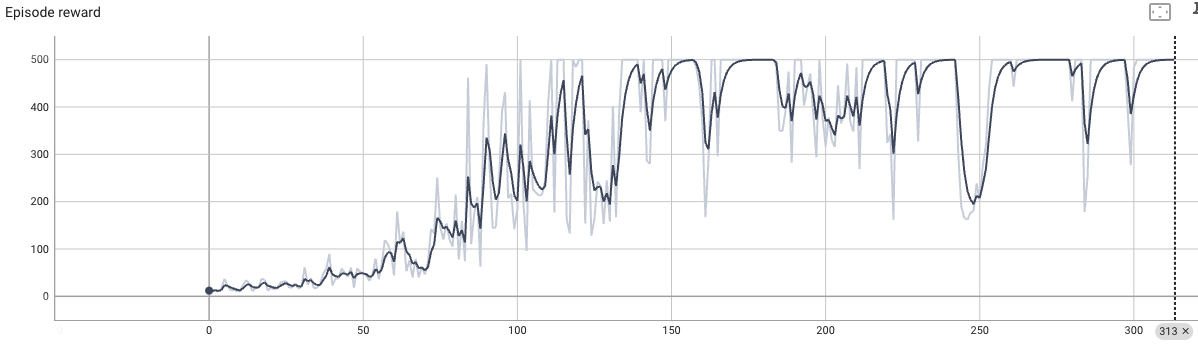

#### Maximum reward:
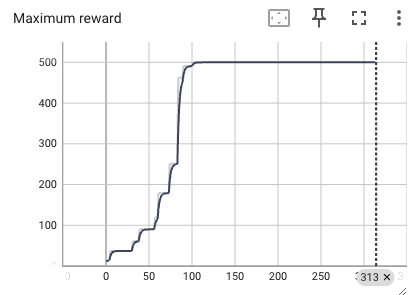